## Preprocess
Preprocess the dataset and convert the posts of two parties into word list  

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
from nltk.corpus import stopwords
import nltk as nlp
import sklearn

data=pd.read_csv("reddit/file_name.csv")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords = stopwords.words('english')
#add some unnecessary word to stopwords list
stopwords.append("rt")
stopwords.append("u")
stopwords.append("amp")
stopwords.append("w")
stopwords.append("th")

data["Text"] = data["Text"].fillna('')
data["Title"] = data["Title"].fillna('')
data['Post'] = data['Title'] + ' ' + data['Text']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\x1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\x1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\x1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Data partition
democrat=data[data["Political Lean"]=="Liberal"]
republican=data[data["Political Lean"]=="Conservative"]

In [3]:
# Cleaning posts 
def clean(post):
    d=post
    d=re.sub(r'http\S+', '', d) #remove links
    d=re.sub("[^a-zA-Z]", " ", d) #remove all characters except letters
    d=d.lower() #convert all words to lowercase
    d=nltk.word_tokenize(d) #split sentences into word
    d=[word for word in d if not word in set(stopwords)] #add to stopwords list if unnecessary words.
    lemma=nlp.WordNetLemmatizer() 
    d=[lemma.lemmatize(word) for word in d] #identify the correct form of the word in the dictionary
    d=" ".join(d)
    return d

def clean_all(party):
    ret=[]
    for d in party.Post:
        d= clean(d)
        ret.append(d)
    return ret

# Handle, Sentence pairs
republican_sentences=[(p,t) for p,t in zip(republican["Id"], clean_all(republican))]
democrat_sentences=[(p,t) for p,t in zip(democrat["Id"], clean_all(democrat))]

In [4]:
print("Democrat (Liberal) posts number of sentences:",len(democrat_sentences))
print("Republican (Conservative) posts number of sentences:",len(republican_sentences))

Democrat (Liberal) posts number of sentences: 8319
Republican (Conservative) posts number of sentences: 4535


In [5]:
def sentence_to_word(sentence):
    post = str(sentence).split()
    post=[word.replace("'","") for word in post]
    post=[word.replace("[", "") for word in post]
    post=[word.replace("]","") for word in post]
    post=[word.replace(",", "") for word in post]
    return post

# Handle, word list pairs
democrat_words=[(p, sentence_to_word(t)) for p,t in democrat_sentences]
republican_words=[(p, sentence_to_word(t)) for p,t in republican_sentences]

In [6]:
print("Democrat (Liberal) post word length:",sum([len(t) for _, t in democrat_words]))
print("Republican (Conservative) post word length:",sum([len(t) for _, t in republican_words]))

Democrat (Liberal) post word length: 229675
Republican (Conservative) post word length: 106403


## Measure with moral foundations dictionary
Setup the moral foundation dictionary and measure the moral foundations of the two parties according to the post words with this dictionary.

In [7]:
MFD2 = 'mfd-2.0.dic'
nummap = dict()
mfd2 = dict()
wordmode = True
category = ["authority", "care", "fairness", "loyalty", "sanctity"]
category_with_valence = []
for c in category:
    category_with_valence.append(c+".vice")
    category_with_valence.append(c+".virtue")
with open(MFD2, 'r') as f:
    for line in f.readlines():
        ent = line.strip().split()
        if line[0] == '%':
            wordmode = not wordmode
        elif len(ent) > 0:
            if wordmode:
                wordkey = ''.join([e for e in ent if e not in nummap.keys()])
                wordkey = wordkey[:-1] if "*" == wordkey[-1] else wordkey
                mfd2[wordkey] = [nummap[e] for e in ent if e in nummap.keys()]
            else:
                nummap[ent[0]] = ent[1]

In [8]:
from collections import defaultdict

def flat_list(data:list):
    """Remove handle and concat word list"""
    ret = []
    for l in data:
        ret += l[-1]
    return ret

def word_count(word_list, category):
    """Count the number of words for different moral foundation classes"""
    ret = {k:0 for k in category}
    for word in word_list:
        if word in mfd2:
            for category in mfd2[word]:
                ret[category] += 1
    return ret

def to_percentage(data):
    """Convert the number to percentage"""
    total = sum([num for _, num in data.items()])
    if total == 0:
        return {k:0for k, v in data.items()}
    ret = {k:v/total for k, v in data.items()}
    assert abs(sum(ret.values())-1) < 0.001, (ret, total)
    return ret

In [9]:
# Count words and convert to percentage
democrat_foundations_count = word_count(flat_list(democrat_words), category_with_valence)
republican_foundations_count = word_count(flat_list(republican_words), category_with_valence)

democrat_foundations_percentage = to_percentage(democrat_foundations_count)
republican_foundations_percentage = to_percentage(republican_foundations_count)

In [10]:
democrat_valid_words = sum([num for _, num in democrat_foundations_count.items()])/len(flat_list(democrat_words))
republican_valid_words = sum([num for _, num in republican_foundations_count.items()])/len(flat_list(republican_words))

print("{}% words are valid and used to measure the moral foundations in **democratic** reddit data".format(round(democrat_valid_words*100, 2)))
print("{}% words are valid and used to measure the moral foundations in **republican** reddit data".format(round(republican_valid_words*100, 2)))

6.25% words are valid and used to measure the moral foundations in **democratic** reddit data
5.75% words are valid and used to measure the moral foundations in **republican** reddit data


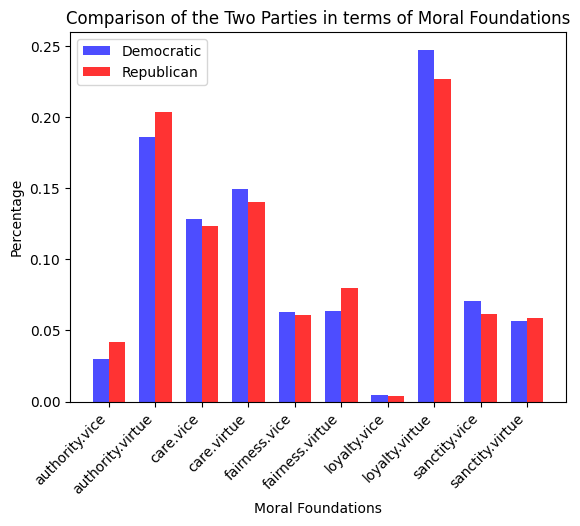

In [11]:
import matplotlib.pyplot as plt

def plot_moral_foundations(democratic_data, republican_data):
    """Bar plot"""
    bar_width = 0.35  # Width of the bars
    positions = np.arange(len(democratic_data))

    # Plotting both datasets
    plt.bar(positions - bar_width/2, democratic_data.values(), bar_width, label='Democratic', color=(0.3, 0.3, 1, 1))
    plt.bar(positions + bar_width/2, republican_data.values(), bar_width, label='Republican', color=(1, 0.2, 0.2, 1))

    # Adding titles, labels, and legend
    plt.title('Comparison of the Two Parties in terms of Moral Foundations')
    plt.xlabel('Moral Foundations')
    plt.ylabel('Percentage')
    plt.xticks(positions, democratic_data.keys(), rotation=45, ha='right')
    plt.legend()

    # Display the plot
    plt.show()

democratic_data = dict(sorted(democrat_foundations_percentage.items()))
republican_data = dict(sorted(republican_foundations_percentage.items()))
plot_moral_foundations(democratic_data, republican_data)

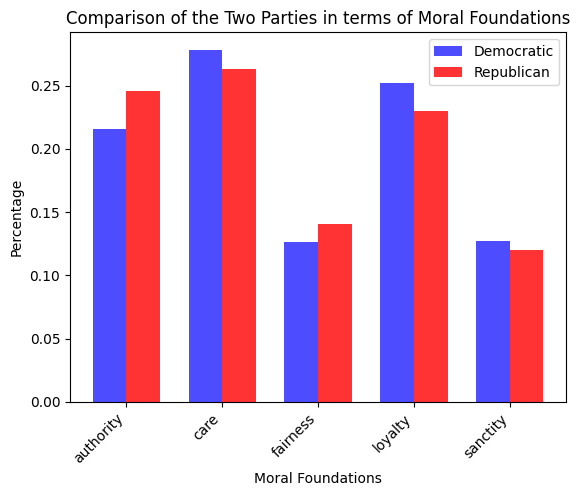

In [12]:
def merge_moral_foundations(data):
    """Merge vice and vritue"""
    ret = {key:0 for key in category}
    for k, v in data.items():
        for c in category:
            if c in k:
                break
            if c==category[-1]:
                raise ValueError
        ret[c] += v
    assert abs(sum(ret.values())-1)<0.001 or abs(sum(ret.values()))<0.001, ret
    return ret

plot_moral_foundations(merge_moral_foundations(democratic_data), 
                       merge_moral_foundations(republican_data))

## Classifier Training
We use logistic regression to build a classifier which takes as input the measured results of a sentences with moral foundation dictionary. The binary output indicates possible party of this man who publish this post.  

In [13]:
# Clean training Data
posts = data.copy()
posts['Post'] = posts['Post'].apply(clean)

### TF-IDF
Get the words with highest importance

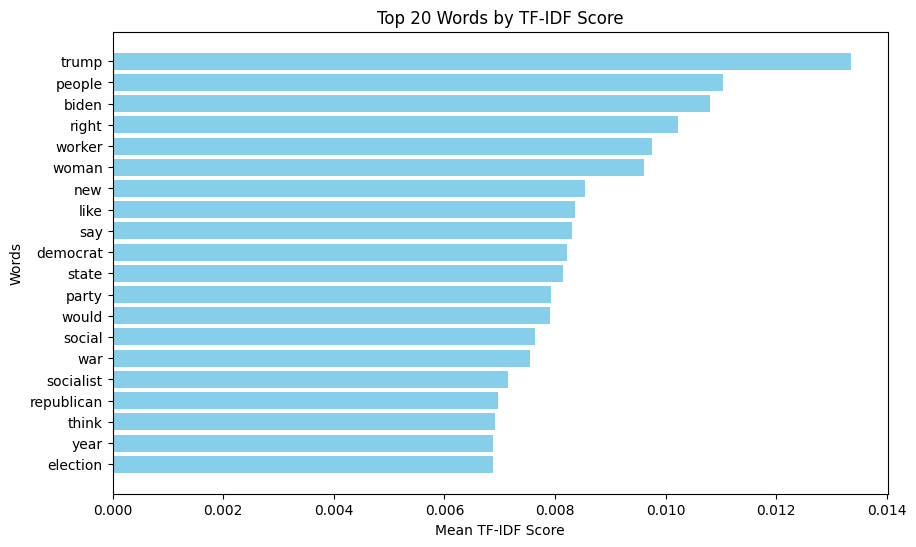

Sparsity of the TfidfVectorizer matrix: 99.90%


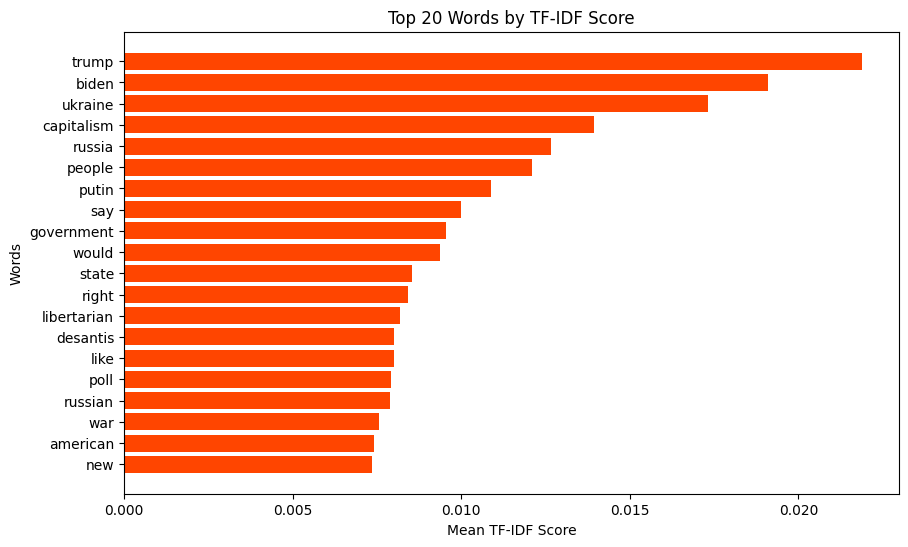

Sparsity of the TfidfVectorizer matrix: 99.86%


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

def calculate_importance(data, color):
    vectorizer = TfidfVectorizer()
    # Generate the TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(data)
    # Convert to a regular array for easier handling
    avg_tfidf = tfidf_matrix.mean(axis=0) 
    avg_tfidf_array = avg_tfidf.A.flatten()
    feature_names = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_avg': avg_tfidf_array})
    # Get the top 20 words
    sorted_tfidf_df = tfidf_df.sort_values(by='tfidf_avg', ascending=False)
    top_20_words = sorted_tfidf_df.head(20)

    # Plotting a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_20_words['word'], top_20_words['tfidf_avg'], color=color)
    plt.xlabel('Mean TF-IDF Score')
    plt.ylabel('Words')
    plt.title('Top 20 Words by TF-IDF Score')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest score at the top
    plt.show()
    
    # Calculate the sparsity
    sparsity = 1.0 - (tfidf_matrix.nnz / float(tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
    print("Sparsity of the TfidfVectorizer matrix: {:.2f}%".format(sparsity * 100))

calculate_importance(posts[posts["Political Lean"]=="Liberal"].Post, "skyblue")
calculate_importance(posts[posts["Political Lean"]=="Conservative"].Post, "orangered")

### Split-dataset

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(posts['Post'],
                                                    posts['Political Lean'],
                                                    stratify=posts['Political Lean'],
                                                    test_size=0.2,
                                                    random_state=1218) # use my birthday!
print("Training set:\n") 
print(y_train.value_counts(),"\n\n==============================\n")
print("Test set:\n") 
print(y_test.value_counts())

Training set:

Political Lean
Liberal         6655
Conservative    3628
Name: count, dtype: int64 


Test set:

Political Lean
Liberal         1664
Conservative     907
Name: count, dtype: int64


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, cohen_kappa_score
from sklearn.model_selection import cross_validate
import json

def fit_model(X_train, y_train, clf, vocabulary=None):
    vectorizer = CountVectorizer(vocabulary=vocabulary) if vocabulary else CountVectorizer()
    post_clf = Pipeline([
        ('vect', vectorizer),
        ('tfidf', TfidfTransformer()),
        ("clf", clf)
    ])
    post_clf.fit(X_train,y_train)
    return post_clf

def evaluate(model_name, y_test, y_pred, labels):
    print("Model: {}\n".format(model_name))
    print(classification_report(y_test, y_pred, target_names=labels))
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's Kappa:", round(kappa,2))
    print("========================================================\n")

def cross_validation(model_name, clf, X, y):
    scoring = ['accuracy', 'precision_macro', 'recall_macro']
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring, return_train_score=True)
    cv_results = {key:[round(n,2) for n in value.tolist()] + [round(float(np.mean(cv_results[key])),2)] for key, value in cv_results.items()}
    max_columns = max(len(values) for values in cv_results.values())
    column_titles = ['Metrics'] + ["Fold" + str(i) for i in range(max_columns-1)] + ["Average"]  # Empty string for the first column title
    print("Cross Validation Result for {}: \n".format(model_name))
    print("{:<25} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format(*column_titles))
    for key, values in cv_results.items():
        row = [key] + values
        print("{:<25} {:<12.2f} {:<12.2f} {:<12.2f} {:<12.2f} {:<12.2f} {:<12.2f}".format(*row))
    print("\n")

### 5-fold Cross validation
Adjust hypter parameters for the classifier

In [17]:
logistic_reg_clf = fit_model(X_train, y_train, LogisticRegression(max_iter=1000, C=7, tol=5e-3))
naive_bayes_clf = fit_model(X_train, y_train, MultinomialNB(alpha = 0.15, fit_prior = True))

cross_validation("Logistic Regression", logistic_reg_clf, X_train, y_train)
cross_validation("Naive Bayesian", naive_bayes_clf, X_train, y_train)

Cross Validation Result for Logistic Regression: 

Metrics                   Fold0        Fold1        Fold2        Fold3        Fold4        Average     
fit_time                  0.93         0.88         0.84         0.90         0.83         0.88        
score_time                0.07         0.06         0.08         0.09         0.08         0.08        
test_accuracy             0.77         0.76         0.77         0.75         0.77         0.77        
train_accuracy            0.96         0.96         0.95         0.96         0.96         0.95        
test_precision_macro      0.76         0.74         0.76         0.73         0.75         0.75        
train_precision_macro     0.96         0.96         0.95         0.96         0.96         0.96        
test_recall_macro         0.74         0.71         0.73         0.71         0.73         0.72        
train_recall_macro        0.94         0.95         0.94         0.95         0.94         0.94        


Cross Valid

### Test Performance

In [18]:
labels = ["Liberal", "Conservative"]
evaluate("Logistic Regression", y_test, logistic_reg_clf.predict(X_test), labels)
evaluate("Naive Bayesian", y_test, naive_bayes_clf.predict(X_test), labels)

Model: Logistic Regression

              precision    recall  f1-score   support

     Liberal       0.72      0.59      0.65       907
Conservative       0.80      0.87      0.83      1664

    accuracy                           0.77      2571
   macro avg       0.76      0.73      0.74      2571
weighted avg       0.77      0.77      0.77      2571

Cohen's Kappa: 0.48

Model: Naive Bayesian

              precision    recall  f1-score   support

     Liberal       0.78      0.48      0.60       907
Conservative       0.77      0.93      0.84      1664

    accuracy                           0.77      2571
   macro avg       0.77      0.70      0.72      2571
weighted avg       0.77      0.77      0.75      2571

Cohen's Kappa: 0.45



### Use MFD as vocabulary
Calculate the word frequency with moral foundation dictionary 

In [19]:
moral_foundation_vocabulary = list(mfd2.keys())
print("Moral Foundation dictionary has {} words:".format(len(moral_foundation_vocabulary)))

logistic_reg_clf = fit_model(X_train, y_train, 
                             LogisticRegression(max_iter=1000, C=14, tol=1e-4),
                             vocabulary=moral_foundation_vocabulary)
naive_bayes_clf = fit_model(X_train, y_train, 
                            MultinomialNB(alpha = 0.1, fit_prior = True),
                            vocabulary=moral_foundation_vocabulary)

evaluate("Logistic Regression", y_test, logistic_reg_clf.predict(X_test), labels)
evaluate("Naive Bayesian", y_test, naive_bayes_clf.predict(X_test), labels)

Moral Foundation dictionary has 2039 words:
Model: Logistic Regression

              precision    recall  f1-score   support

     Liberal       0.45      0.11      0.17       907
Conservative       0.66      0.93      0.77      1664

    accuracy                           0.64      2571
   macro avg       0.56      0.52      0.47      2571
weighted avg       0.59      0.64      0.56      2571

Cohen's Kappa: 0.04

Model: Naive Bayesian

              precision    recall  f1-score   support

     Liberal       0.47      0.07      0.13       907
Conservative       0.65      0.95      0.78      1664

    accuracy                           0.64      2571
   macro avg       0.56      0.51      0.45      2571
weighted avg       0.59      0.64      0.55      2571

Cohen's Kappa: 0.03

